In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, glob,warnings, glob
from scipy.stats import *
from itertools import combinations
from astropy.io import fits
import pickle
import seaborn as sns
import healpy as hp

In [8]:
data_file = glob.glob('./data_file/*')
data_file

['./data_file/_sims_maf_fbs_2_0_vary_nes_vary_nes_nesfrac1_00_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_USER.npz',
 './data_file/_sims_maf_fbs_2_0_vary_expt_vary_expt_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_USER.npz',
 './data_file/_sims_maf_fbs_2_0_baseline_baseline_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_USER.npz']

In [9]:
maf = {}
for db in data_file:
    tmp = np.load(db) # FBB we dont use dumb as its abelist
    tmp.allow_pickle = True
    maf[db]= tmp['metricValues'][np.where(tmp['mask']==False)]

In [10]:
dist_file = glob.glob('./dist_file/*')
dist_file

['./dist_file/_sims_maf_fbs_2_0_vary_nes_vary_nes_nesfrac1_00_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_HEAL.npz',
 './dist_file/_sims_maf_fbs_2_0_vary_expt_vary_expt_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_HEAL.npz',
 './dist_file/_sims_maf_fbs_2_0_baseline_baseline_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_HEAL.npz']

In [11]:
# how are maf and dist different??
dist = {}
for db in dist_file:
    print(db)
    _tmp_= np.load(db)
    _tmp_.allow_pickle = True
    dist[db]= _tmp_['metricValues'][np.where(_tmp_['mask']==False)]  

./dist_file/_sims_maf_fbs_2_0_vary_nes_vary_nes_nesfrac1_00_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_HEAL.npz
./dist_file/_sims_maf_fbs_2_0_vary_expt_vary_expt_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_HEAL.npz
./dist_file/_sims_maf_fbs_2_0_baseline_baseline_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_HEAL.npz


In [12]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, extra=0, 
                       facecolor='none', **kwargs):
    # FBB what is extra? not defined in the doc string
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2 , 
                      height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0] + extra) / 2 * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1] + extra) / 2 * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [13]:
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec


In [30]:
from matplotlib.patches import Circle
import matplotlib.transforms as transforms

def limits(x1,y1,x2,y2,ax,facecolor='none', **kwargs):
    xc,yc= np.mean(x2),np.mean(y2)
    if len(x1)>0:
        dist=np.linalg.norm(np.column_stack([x1,y1])-np.array([xc,yc]),axis=1)
        r = dist[np.argmin(dist)]
        print(r)
        circle = Circle((xc,yc), radius = r,
                      facecolor='None',edgecolor='black', **kwargs, linewidth=2)
    else:
        dist=np.linalg.norm(np.column_stack([x2,y2])-np.array([xc,yc]), axis=1)
        r = dist[np.argmax(dist)]
        circle = Circle((xc,yc), radius = 3*r, facecolor='None',edgecolor='black',linewidth=3)   
    return ax.add_patch(circle)

vary_nes_nesfrac1_00 0
1687
vary_nes_nesfrac1_00 0 0.0
{'vary_nes_nesfrac1_00': {0: 2}}
vary_nes_nesfrac1_00 1
1213
vary_nes_nesfrac1_00 1 0.018731117824773415
1.2151654280639446
{'vary_nes_nesfrac1_00': {0: 2, 1: 2}}
vary_nes_nesfrac1_00 2
1725
vary_nes_nesfrac1_00 2 0.0396
0.841275315289477
{'vary_nes_nesfrac1_00': {0: 2, 1: 2, 2: 2}}
baseline 0
1487
baseline 0 0.0
{'vary_nes_nesfrac1_00': {0: 2, 1: 2, 2: 2}, 'baseline': {0: 2}}
baseline 1
2810
baseline 1 0.0086
1.6319675176670247
{'vary_nes_nesfrac1_00': {0: 2, 1: 2, 2: 2}, 'baseline': {0: 2, 1: 2}}
baseline 2
2000
baseline 2 0.034289151794666135
0.8875817884911111
{'vary_nes_nesfrac1_00': {0: 2, 1: 2, 2: 2}, 'baseline': {0: 2, 1: 2, 2: 2}}
vary_expt 0
1463
vary_expt 0 0.0
{'vary_nes_nesfrac1_00': {0: 2, 1: 2, 2: 2}, 'baseline': {0: 2, 1: 2, 2: 2}, 'vary_expt': {0: 2}}
vary_expt 1
2639
vary_expt 1 0.002228525121555916
2.5506531398748042
{'vary_nes_nesfrac1_00': {0: 2, 1: 2, 2: 2}, 'baseline': {0: 2, 1: 2, 2: 2}, 'vary_expt': {0: 2, 

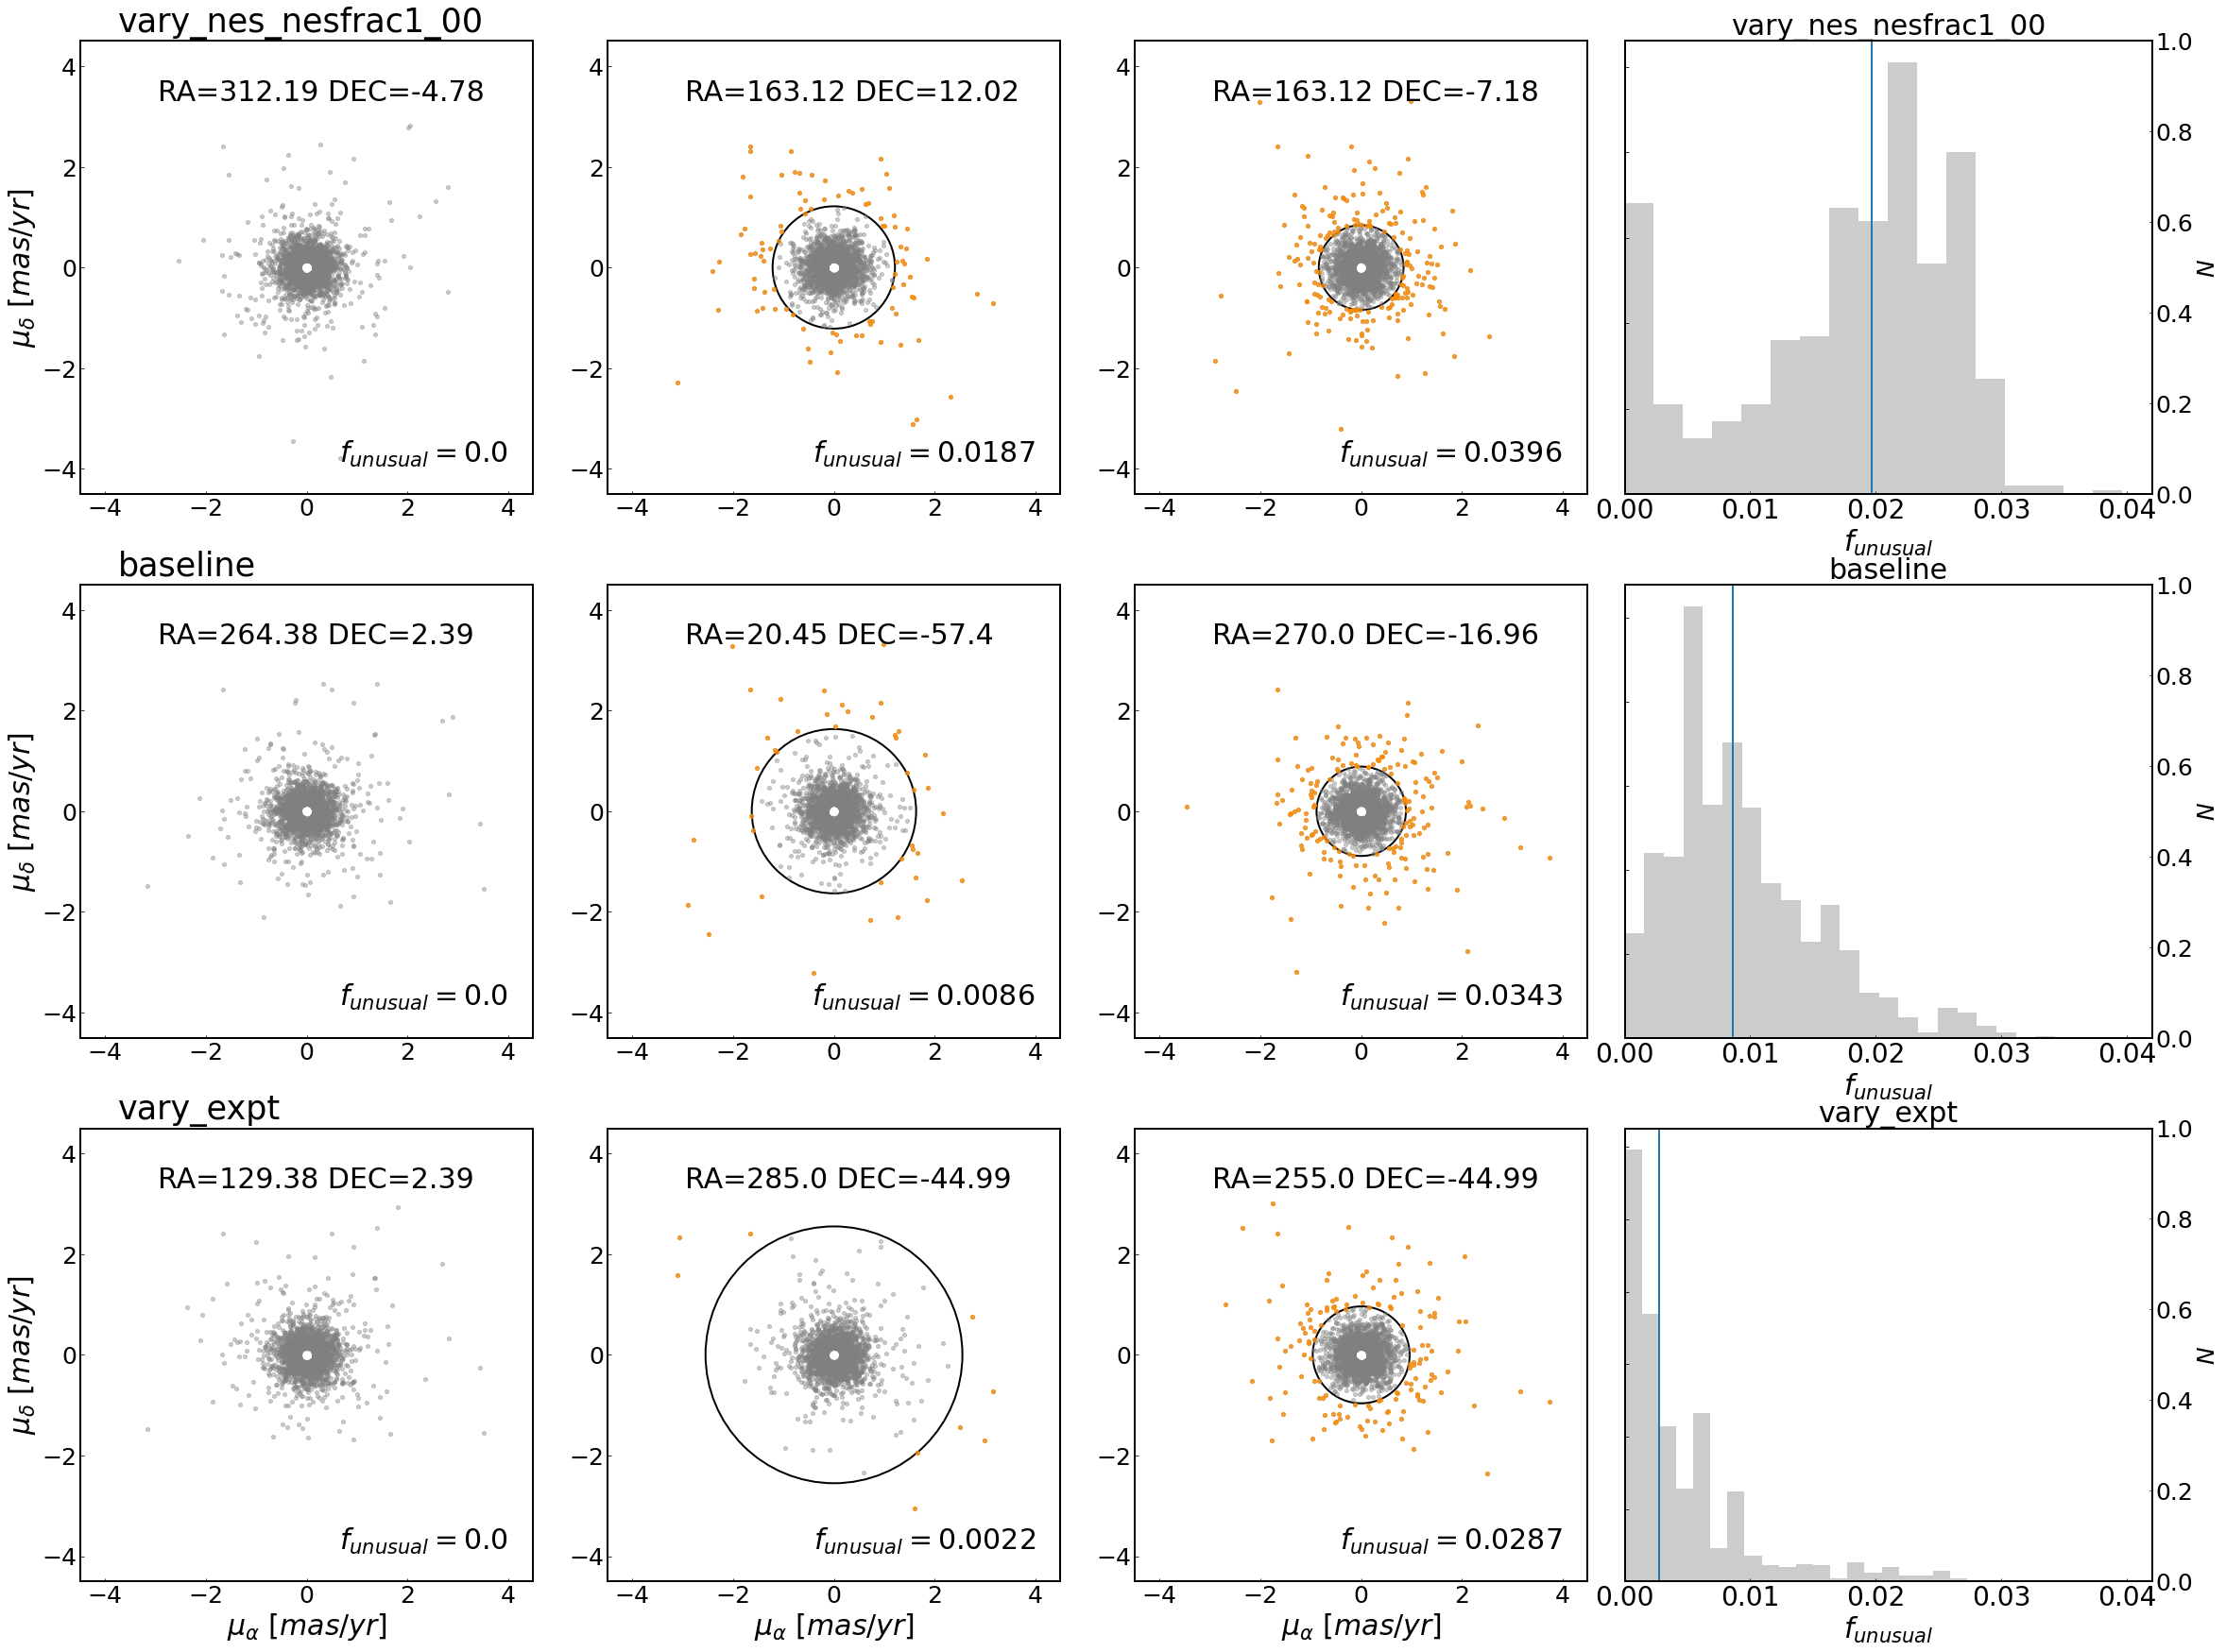

In [39]:
plt.rcParams['font.size'] = 28
fig, axs= plt.subplots(3,4,figsize=(40,30))
#fig, axs = plt.subplots(ncols=14, nrows=2, figsize=(5.5, 3.5),
#                        constrained_layout=True)
# add an artist, in this case a nice label in the middle...

#plt.tight_layout()
npointsout = {} #points that will end up outside the plot
for j, (x,t) in enumerate(zip(['vary_nes',
                              'baseline','vary_expt'],
                      ['vary_nes_nesfrac1_00',
                              'baseline','vary_expt'])):
    #create the file name which is used as key in the dictionary
    d = "./data_file/_sims_maf_fbs_2_0_%s_%s"%(x, t)
    d = d + "_v2_0_10yrs_db_LS_newrun_proposalID_1_and_note_not_like_DD_and_nightgt_0_and_nightlt730_USER.npz"
    
    #extract the metric value for all fields
    detected = np.array([(maf[d][i]["detected"] if not maf[d][i] is None else np.nan) for i in range(len(maf[d])) ])
    
    #sort by metric value - make sure you account for NaNs
    indx = np.argsort(detected)
    nans = np.isnan(detected).sum()
    
    npointsout[t] = {}
    median = int((len(detected) - nans) / 2 )
    
    for i in [0,1,2]:
        axs[j,i].set(adjustable='box', aspect=1)
        if i==0:
            m = maf[d][indx[0]] # minimum LS result
        if i==1:
            m = maf[d][indx[median]] # median LS result
        if i==2:
            m = maf[d][indx[-nans-1]] # best LS result
        print(t, i)
        #some renormalization       
        pm = m['PM'] * 10**3 #usual
        #print(pm)
        pm_un = m['PM_un'] * 10**3 #unusual
        pm_un_det = m['PM_un_det'] * 10**3 #unusual and detected
        #pixel id
        pix = m['pixID']
        print(pix)
        #fraction detected
        det = m['detected'] #FBB same as len(m['PM_un_det']) / len(m['PM_un']))
        #FBB what is this?
        print(t, i, det)
        sigma = m['sigma'] #FBB dunno what this is
        #print(np.size(pm))
        #n_in = np.size(pm.pm_alpha)
        #contour = confidence_ellipse(pm.pm_alpha, pm.pm_delta, 
        #                             #FBB what is this extra??
        #                             n_std=3.0, extra=sigma, ax=axs[j,i],
        #                             #label=r'$3\sigma$', 
        #                             edgecolor='black', linestyle='-', 
        #                             linewidth=3, zorder=100)
        contour =  limits(pm_un_det.pm_alpha,pm_un_det.pm_delta,pm.pm_alpha, 
                          pm.pm_delta,ax=axs[j,i]) #confidence_ellipse(pm.pm_alpha, pm.pm_delta,n_std=3.0, extra=sigma**2,ax=axs[j,i],label=r'$3\sigma$', 
                             #        edgecolor='black', linestyle='-', linewidth=3, zorder=100)
        
        # go to data coordinates to plot points
        points = axs[j,i].transData.transform(np.array([pm_un.pm_alpha, 
                                                        pm_un.pm_delta]).T)
        id_p = contour.contains_points(points)
        
        #n_out = np.size(pm_un.pm_alpha[id_p])
        #print(np.sum(id_p))
        #ax.plot(p_[:,0],p_[:,1],'-',color='black',lw=2)
        axs[j,i].scatter(pm_un.pm_alpha,pm_un.pm_delta, marker='h',s=20, 
                         color='grey',alpha =0.4)
        axs[j,i].scatter(pm_un_det.pm_alpha,pm_un_det.pm_delta, marker='h',s=20, 
                         color='darkorange',alpha=0.7)
        npointsout[t][i] = (np.array(pm_un.pm_alpha < -4.35) + np.array(pm_un.pm_alpha > 4.35) + \
                    np.array(pm_un.pm_delta < -4.35) + np.array(pm_un.pm_delta > 4.35)).sum()
        #axs[j,i].text(-.07,2.05,r'$3\sigma$',  weight='bold', fontsize=35,color='darkred')
        #axs[j,i].text(-.07,0.03,r'$1\sigma$', weight='bold',fontsize=20,color='darkred',zorder=100)
        #fig2, ax2 = plt.subplots(1,2)
        #ax2[0].hist(pm_un.pm_alpha, bins=100)
        #ms, ts = np.mean(pm_un.pm_alpha), np.std(pm_un.pm_alpha)
        #ax2[0].axvline(ms-3*ts)
        #ax2[0].axvline(ms+3*ts)
        #ax2[1].hist(pm_un.pm_delta, bins=100)
        #ms, ts = np.mean(pm_un.pm_delta), np.std(pm_un.pm_delta)
        #ax2[1].axvline(ms-3*ts)
        #ax2[1].axvline(ms+3*ts)
        axs[j,i].set_xlim([-4.5, 4.5])
        axs[j,i].set_ylim([-4.5, 4.5])
        axs[j,i].set_yticks([-4, -2, 0, 2, 4])
        if j == 2:
            axs[j,i].set_xlabel(r'$\mu_{\alpha}$ '+r'$[mas/yr]$',fontsize=30)
        if i == 0:
            axs[j,i].set_ylabel(r'$\mu_{\delta}$ '+r'$[mas/yr]$',fontsize=30)
        #axs[j,i].set_title('{}'.format(t), fontsize=25)
        RA,DEC= pix2radec(16,pix)
        axs[j,i].tick_params('both', labelsize=25)
        axs[j,i].annotate('RA={} DEC={}'.format(np.round(RA,2),np.round(DEC,2)),
                  (-2.95,3.75),fontsize=30,fontweight=3, ha='left', va="top")
        axs[j,i].annotate(r'$f_{unusual}= $'+r'${}$'.format(np.round(det,4)),
                  (4,-4),fontsize=30,fontweight=3, ha='right', va="bottom")
        print(npointsout)
        for axis in ['top','bottom','left','right']:
            axs[j,i].spines[axis].set_linewidth(2)
 
    distfile = d.replace("data_file", "dist_file").replace("USER.npz", "HEAL.npz")
    #axs[j,3].hist(dist[distfile])
    sns.distplot(dist[distfile], ax=axs[j,3], 
                bins=int(2 * np.power(np.size(dist[distfile]), 1/3.)),
                hist=True, kde=False, rug=False, fit=None, hist_kws={'alpha':0.4,'lw':3,'color':'grey'}, )
    axs[j,3].set_title('{}'.format(t), fontsize=30)
    axs[j,3].set_xlabel(r'$f_{unusual}$',fontsize=30)
    ax2 = axs[j,3].twinx()
    ax2.set_ylabel(r'$N$',fontsize=25)
    ax2.yaxis.set_label_position("right")
    # move ticks
    

    axs[j,3].set_xlim([0,0.042])
    axs[j,3].set_yticklabels( '', fontsize=25)
    ax2.tick_params('both', labelsize=25)

    
    _ = np.median(dist[distfile][np.isfinite(dist[distfile])])
    axs[j,3].axvline(_, linewidth=2)
    axs[j,3].text(-0.12, axs[j,3].get_ylim()[1] * 1.02, 
                  '{}'.format(t), fontsize=35, ha='left')
    for axis in ['top','bottom','left','right']:
            axs[j,3].spines[axis].set_linewidth(2)
    #axs[j,3].set_ylim([0,150])
    #axs[j,3].set_aspect(aspect='equal',adjustable='box')
plt.subplots_adjust(wspace = 0, left=None, right=None)
    
plt.savefig('contour_plot.png')